In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly

Constructing a function $f(x)$

In [2]:
f = lambda x : x**2
print f(4)

16


Construct the dual $f^*$ of $f$. The dual of a function it is a "something" a point that given a function returnes a value.

In [3]:
x = lambda f: f(4.)
g = lambda x: x**2
print x(g)

16.0


Construct a set of this special points, that given a function return a value, we call this set $\hat N$ (the **set of nodal functions**, that are a basis for the dual space of $\hat{\mathcal{P}}^k([0,1])$). 

In [4]:
def construct_dofs():
    N = []
    N.append(lambda f: f(0.))
    N.append(lambda f: f(.5))
    N.append(lambda f: f(1.))
    return N

In [5]:
p = lambda p : p(0)
f = lambda x : x

Nk = construct_dofs()

print Nk
print Nk[0](f)
print Nk[1](f)

[<function <lambda> at 0x105bc37d0>, <function <lambda> at 0x105bc36e0>, <function <lambda> at 0x105bc3b18>]
0.0
0.5


$\mathcal{P}^k([0,1]) = \textrm{span}\{e_i\}_{i=0}^k =: \textrm{span} E$
As we are free to choose our polinomials, we pick them in their simplest possible form, monomials:
$$
e_i = \mathrm{pow}(x,i)
$$

In [6]:
def construct_poly(deg):
    E = []
    for i in range(deg+1):
        c = np.zeros((i+1,))
        c[-1] = 1
        E.append(poly.Polynomial(c))
    return E

In [7]:
deg = 2

In [8]:
Tk = np.array([0,1])
Nk = construct_dofs()
Pk = construct_poly(deg)
print Pk

[Polynomial([ 1.], [-1.,  1.], [-1.,  1.]), Polynomial([ 0.,  1.], [-1.,  1.], [-1.,  1.]), Polynomial([ 0.,  0.,  1.], [-1.,  1.], [-1.,  1.])]


We construct basis functions $v_i$ asking them to be those particular polynomials orthogonal to the degrees of freedom $v^j$. In a compact way this means:

$$
v^j\, v_i = \delta^j_i
$$

$v^j$ are a special kind of points that given a function the do return a value. We can write this value for the $k$-th polynomial:

$v^j(e_k)$, and introduce the matrix $C_k^j$. This matrix clarifies the way canonical basis functions are related with the degrees of freedom:


$$
v^j\, v_i = \delta^j_i, \quad v^j(e_k)\, v^k_i = \delta^j_i, \quad C^j_k\, v^k_i = \delta^j_i
$$

Reading the last formula we get an easy way to construct the basis functions:

$$
v^k_i = (C^j_k)^{-1}\delta^j_i
$$

In practice these $v^k_i$ are the cofficents for the polynomials that are going to become the basis for our space.  

In [9]:
def construct_cij(N,P):
    C = np.zeros((0,len(N))) # Matrix for the change of variables
    for dof in N:
        row = np.array([])
        for p in P:
            row = np.hstack((row,[dof(p)]))
        C = np.vstack((C,row))
    return C

In [10]:
def construct_canonical_basis(C):
    V = []
    for k in range(C.shape[0]):
        delta_ij = np.zeros((C.shape[0],))
        delta_ij[k] = 1. # delta_ik
        vk = np.linalg.solve(C, delta_ij)
        V.append(poly.Polynomial(vk)) # Construct the basis using the right coefficients of the polynomials
    return V

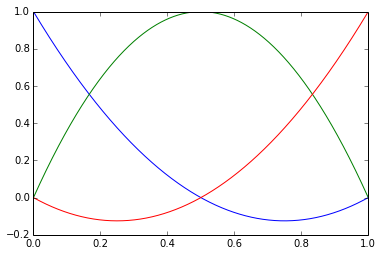

In [11]:
C = construct_cij(Nk,Pk)

V = construct_canonical_basis(C)


s = np.linspace(0,1,1025)
for v in V:
    plt.plot(s, v(s))
plt.show()

In [14]:
from numpy.polynomial.legendre import leggauss

def assemble_system(x,V,myf):
    
    h = 1./(len(x)-1)

    degree = 2*len(V)-1
    q,w = leggauss(degree) # Gauss between -1 and 1
    q = (q+1)/2 # Go back to 0,1 
    w = w/2
    
    Vq = np.zeros((len(V), len(q)))
    Vpq = np.zeros((len(V), len(q)))

    for i in range(len(V)):
        Vq[i] = V[i](q)
        Vpq[i] = V[i].deriv()(q)

    n_dofs = (len(x)-1)*(len(V)-1)+1

    A = np.zeros((n_dofs, n_dofs))
    rhs = np.zeros((n_dofs,))

    # Construct the local matrix only once:
    local_A = np.einsum('jq, iq, q -> ij', Vpq/h, Vpq/h, w*h)

    for i in range(len(x)-1):
        start = i*(len(V)-1)
        end = start+len(V)

        index = range(start, end)
        A[np.ix_(index, index)] += local_A

        # The transformation of the quadrature points
        xq = x[i]+h*q
        local_rhs = np.einsum('iq, q, q -> i', Vq, w*h, myf(xq))

        rhs[index] += local_rhs

    # Fix the boundary conditions
    A[0] = 0
    A[0,0] = 1
    rhs[0] = 0

    A[-1] = 0
    A[-1,-1] = 1
    rhs[-1] = 0        

    return A,rhs

In [42]:
def evaluate_error(x,V,u,exact_sol):
    h = 1./(len(x)-1)

    degree = 2*len(V)-1
    q,w = leggauss(degree) # Gauss between -1 and 1
    q = (q+1)/2 # Go back to 0,1 
    w = w/2
    
    Vq = np.zeros((len(V), len(q)))
    
    for i in range(len(V)):
        Vq[i] = V[i](q)
        
    error = 0.
    
    for i in range(len(x)-1):
        start = i*(len(V)-1)
        end = start+len(V)

        index = range(start, end)
        xq = x[i]+h*q

        fem_sol_k = np.einsum('i,iq -> q', u[index],Vq)
        exact_sol_k = exact_sol(xq)
        
        sq_error = (exact_sol_k-fem_sol_k)**2. 
        
        error += np.einsum('i,i', sq_error,w)

    return np.sqrt(error)

In [16]:
def interpolation_matrix(s, x, V):
    """
    Given the evaluation points s in the mesh x, construct the interpolation matrix 
    according to the local basis V.
    """
    n_dofs = (len(x)-1)*(len(V)-1)+1

    M = np.zeros((n_dofs, len(s)))
    for i in range(len(x)-1):
        index = s>=x[i]
        index *= s<=x[i+1]
        
        # Transform the points to [0,1]
        xi = (s[index]-x[i])/(x[i+1]-x[i])
        
        for j in range(len(V)):
            k = i*(len(v)-1)+j
            M[k,index] = V[j](xi)
    return M

In [15]:
n = 9

x=np.linspace(0,1,n)

myf = lambda x: 4*np.pi**2*np.sin(2*np.pi*x)

A2, rhs = assemble_system(x,V,myf)

# Solve the system
ufem = np.linalg.solve(A2, rhs)

('Error at the s points:', 0.0035860448479723139)
('Error at the x points:', 3.284039706841213e-13)


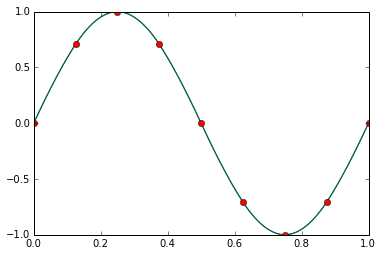

In [17]:
s = np.linspace(0,1,1025)
us = np.sin(2*np.pi*s)
ux = np.sin(2*np.pi*x)

# Use this to plot high resolution versions
M = interpolation_matrix(s,x,V)

# Use this to compute errors at the mesh points
Mx = interpolation_matrix(x,x,V)

plt.plot(s, M.T.dot(ufem))
plt.plot(s, us)
plt.plot(x, ux,'ro')

print("Error at the s points:", (M.T.dot(ufem)-us).max())
print("Error at the x points:", (Mx.T.dot(ufem)-ux).max())

In [43]:
exact_sol = lambda x: np.sin(2*np.pi*x)
print evaluate_error(x,V,ufem,exact_sol)

0.0055206173826
